#### Define helper method to render inside of jupyter notebook

In [1]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

def show_state(env, step=0, info=""):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id,step,info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

# CartPole

## Aufgabe 2

Löse das CartPole-v0 (https://gym.openai.com/envs/CartPole-v0/) Environment mittels des bereits bekannten Q-Learning. Beachte hierbei das es sich um einen continuous Statespace handelt und dieser für den tabellelarischen Ansatz zuerst in einen discrete Space transformiert werden muss.

**Hinweis:** Für die Lösung müssen nicht alle zur Verfügung stehenden Eingabefeatures genutzt werden. 

### Übersicht über die vom Environment bereitgestellten Features und deren Wertebereiche

- x (Wagenposition) ∈ [-4.8, 4.8]
- x’ (Wagengeschwindigkeit) ∈ [-3.4 10^38, 3.4 10^38]
- theta (Neigungswinkel) ∈ [-0.42, 0.42]
- theta’ (Winkelgeschwindigkeit) ∈ [-3.4 10^38, 3.4 10^38]

In [2]:
%run ../setup.ipynb

In [3]:
import math

def discretize(env, buckets, obs):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

In [4]:
from lib.statistics import plot
import time
import numpy as np
from collections import deque
from contextlib import suppress

def interact_with_environment(env, agent, buckets=None, n_episodes=400, max_steps=200, train=True, verbose=True):      
    statistics = []
    
    with suppress(KeyboardInterrupt):
        for episode in range(n_episodes):
            done = False
            total_reward = 0
            state = env.reset()
            if buckets:
                state = discretize(env, buckets, state) # transform state
            episode_start_time = time.time()

            for t in range(max_steps):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                if buckets:
                    next_state = discretize(env, buckets, next_state)

                if train:
                    agent.train((state, action, next_state, reward, done))

                state = next_state
                total_reward += reward

                if done:
                    break

            if verbose and episode % 10 == 0:
                speed = t / (time.time() - episode_start_time)
                print(f'episode: {episode}/{n_episodes}, score: {total_reward}, steps: {t}, '
                      f'e: {agent.epsilon:.3f}, speed: {speed:.2f} steps/s')

            statistics.append({
                'episode': episode,
                'score': total_reward,
                'steps': t
            })
        
    return statistics

### 2.1

Laut Schätzungen von Astonomen besteht das Universum aus etwa $10^{80}$ Atome. Ausgeschrieben sind das  100000000000000000000000000000000000000000000000000000000000000000000000000000000 Atome. Wie viele Zustände können in dem CartPole Environment auftreten, wenn die oben angegebenen Wertebereiche betrachtet werden? Welches Problem ergibt sich daraus für die Reinforcement Learning Aufgabe?

- x (Wagenposition) ∈ [-4.8, 4.8]
- x’ (Wagengeschwindigkeit) ∈ [-3.4 10^38, 3.4 10^38]
- theta (Neigungswinkel) ∈ [-0.42, 0.42]
- theta’ (Winkelgeschwindigkeit) ∈ [-3.4 10^38, 3.4 10^38]

### 2.2
Implementiere in **q_learning_agent.py** einen Agenten, der in der Lage ist das CartPole Environment mittels Q-Learning zu lösen.

In [5]:
import gym
env = gym.make('CartPole-v0')

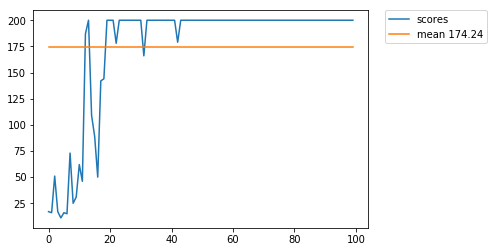

In [24]:
from q_learning_agent import AdvancedQLearning

action_size = env.action_space.n

# Hyperparams
gamma = 1
epsilon = 0.75
epsilon_min = 0.01
alpha = 0.75
alpha_min = 0.01
buckets = (1, 1, 10, 5)

agent = AdvancedQLearning(action_size=action_size, buckets=buckets, gamma=gamma, 
                          epsilon=epsilon, epsilon_min=epsilon_min, 
                          alpha=alpha, alpha_min=alpha_min)

statistics = interact_with_environment(env, agent, buckets, n_episodes=100, verbose=False)
plot(statistics)

#discretize(env, buckets, obs)

#### Hyperparameter Tuning mittels GridSearch

In [19]:
# from lib.hyperparameter_optimization import GridSearch
from functools import partial

grid_search = GridSearch(
    # TODO: Set hyperparams for GridSearch
    grid_params = {
        'gamma': [0.99, 0.75],
        'epsilon': [0.99, 0.75],
        'alpha': [0.99, 0.75],
        'alpha_min': [0.1, 0.01, 0.001],
        'epsilon_min': [0.1, 0.01, 0.001],
        'buckets': [(1, 1, 10, 5)]
    },
    fixed_params = {
        'action_size': env.action_space.n
    },
    construct_env = partial(gym.make, 'CartPole-v0'),
    construct_agent = AdvancedQLearning,
    evaluation_func = interact_with_environment,
    grid_params_for_evaluation_func = ['buckets'],
    score_parameter = 'score'
)
grid_search.run()

INFO:lib.hyperparameter_optimization:About to evaluate 72 parameter sets.
episode: 0/400, score: 17.0, steps: 16, e: 0.941, speed: 7057.40 steps/s
episode: 0/400, score: 30.0, steps: 29, e: 0.712, speed: 8038.25 steps/s
episode: 0/400, score: 23.0, steps: 22, e: 0.712, speed: 5489.60 steps/s
episode: 0/400, score: 21.0, steps: 20, e: 0.941, speed: 4388.49 steps/s
episode: 0/400, score: 21.0, steps: 20, e: 0.941, speed: 4283.62 steps/s
episode: 0/400, score: 20.0, steps: 19, e: 0.941, speed: 1789.06 steps/s
episode: 0/400, score: 22.0, steps: 21, e: 0.712, speed: 4740.60 steps/s
episode: 0/400, score: 26.0, steps: 25, e: 0.712, speed: 3912.45 steps/s
episode: 10/400, score: 16.0, steps: 15, e: 0.563, speed: 12392.07 steps/s
episode: 10/400, score: 39.0, steps: 38, e: 0.563, speed: 13037.51 steps/s
episode: 10/400, score: 13.0, steps: 12, e: 0.563, speed: 11184.81 steps/s
episode: 10/400, score: 17.0, steps: 16, e: 0.427, speed: 12506.31 steps/s
episode: 10/400, score: 65.0, steps: 64, e

### 2.3
Implementiere in **dqn_agent.py** einen Agenten, der in der Lage ist das CartPole Environment mittels DQN zu lösen.

In [26]:
from dqn_agent import DQN

action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# Hyperparams
annealing_steps = 1000  # not episodes!
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = (epsilon - epsilon_min) / annealing_steps
alpha = 0.01
batch_size = 32
memory_size = 10000
start_replay_step = 2000
target_model_update_interval = 1000

agent = DQN(action_size=action_size, state_size=state_size, gamma=gamma, 
            epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, 
            alpha=alpha, batch_size=batch_size, memory_size=memory_size,
            start_replay_step=start_replay_step, 
            target_model_update_interval=target_model_update_interval)

statistics = interact_with_environment(env, agent, verbose=True)
env.close()
plot(statistics)

/opt/conda/envs/ai-lab-hska-rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/ai-lab-hska-rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/ai-lab-hska-rl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/ai-lab-hska-rl/lib/python3.6/site-packages

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


AttributeError: 'ImageData' object has no attribute 'data'

In [25]:
from gym.wrappers import Monitor
from lib.statistics import html_video_embedding

# capture every episode and clean 'video' folder before each run
env = gym.make('CartPole-v0')
env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True, uid='id')
statistics = interact_with_environment(env, agent, n_episodes=10, train=False, verbose=False)
env.close()

plot(statistics, y_limits=(0,200))
html_video_embedding(statistics)

AttributeError: 'ImageData' object has no attribute 'data'